TODO
- Explain network parameters
- Add tasks

In [1]:
import h5py
import numpy as np
import os
import time
import copy

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)

In [2]:
notebook_start_time = time.time()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [4]:
torch.manual_seed(1703) # we fix the random number generators here for the purpose of reproducibility
np.random.seed(1703)

## Network and training parameters

In [5]:
batch_size = 128
learning_rate = 1e-3
max_epochs = 75

## Data set

The data set and issues with data loading are discussed in more detail in the workshop on data processing.

In [6]:
class CyGNSSDataset(Dataset):
    def __init__(self, flag, input_v_map=['brcs'], normalization_values=None, filter_quality=False):
        '''
        Load data and apply transforms during setup

        Parameters:
        -----------
        flag : string
            Any of train / valid / test. Defines dataset.
        input_v_map : list
            Input maps, choice of ['brcs', 'eff_scatter']
        normalization_values : dict
            Mean and standard deviation, needed for scaling the input variables
        filter_quality : bool
            Filter samples that are flagged as bad quality (default: False)
        -----------
        Returns: dataset
        '''
        self.h5_file = h5py.File(os.path.join('data_regression_cygnss', flag + '_data.h5'), 'r', rdcc_nbytes=0)  # disable cache
        # load everything into memory
        start_time = time.time()
        
        # load labels
        self.y = self.h5_file['windspeed'][:].astype(np.float32)

        # normalize main input data
        # Save normalization values together with the trained model
        # For inference load the normalization values

        if flag=='train': # determine normalization values
            self.normalization_values = dict()
        else:
            self.normalization_values = normalization_values
        
        # stack map vars (2D vars)
        self.X = []
        for v_map in input_v_map:
            X_v_map = self.h5_file[v_map][:].astype(np.float32)
            
            if flag=='train':
                norm_vals = dict()
                X_v_map, X_mean, X_std = self._standard_scale(X_v_map)
                self.normalization_values[f'{v_map}_mean'] = X_mean
                self.normalization_values[f'{v_map}_std']  = X_std
            else:
                X_mean = self.normalization_values[f'{v_map}_mean']
                X_std = self.normalization_values[f'{v_map}_std']
                X_v_map = self._standard_scale_given(X_v_map, X_mean, X_std)
                
            self.X.append(X_v_map) # append scaled 2D map
        self.X = np.stack(self.X, axis=1)
        
        if filter_quality:
            n_before = len(self.y)
            mask = self.h5_file['quality'][:]
            self.X, self.y = self.X[mask], self.y[mask]
            print(f'After filter_quality, {len(self.y)} samples remain ({len(self.y)/n_before*100:.1f}%)')

        print(f'load and transform {flag} input data: {self.X.shape} ({self.X.nbytes // 1e6}MB)')
        print(f'load and transform {flag} labels: {self.y.shape} ({self.y.nbytes // 1e6}MB)')
        
    def _standard_scale(self, v):
        '''apply standard scale and return mean / std'''
        mean = np.mean(v)
        sigma = np.std(v)
        v_tilde = (v - mean) / sigma
        return v_tilde, mean, sigma
    
    def _standard_scale_given(self, v, mean, sigma):
        '''apply standard scale with pre-determined mean / std'''
        v_tilde = (v - mean) / sigma
        return v_tilde

    def _filter_all_data_by_mask(self, mask, flag, name=''): 
        self.X, self.y = self.X[mask], self.y[mask]
        print(f'{flag} input data after {name} downsampling: {self.X.shape} ({self.X.nbytes // 1e6}MB)')

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return (X, y)


In [7]:
def setup_dataloaders(filter_quality=False, input_v_map=['brcs']):
    '''Load the datasets and create PyTorch dataloaders'''
    
    train_dataset = CyGNSSDataset('train', filter_quality=filter_quality, input_v_map=input_v_map)
    valid_dataset = CyGNSSDataset('valid', filter_quality=filter_quality, input_v_map=input_v_map, normalization_values=train_dataset.normalization_values)
    test_dataset = CyGNSSDataset('test', filter_quality=filter_quality, input_v_map=input_v_map, normalization_values=train_dataset.normalization_values)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    
    return train_dataloader, valid_dataloader, test_dataloader

## Model

### Define the architecture

In [8]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, units_dense1=64, units_dense2=32, dropout_dense1=0, dropout_dense2=0, input_shape=(1, 17, 11)):
        super(FullyConnectedNetwork, self).__init__()
        self.fc1 = nn.Linear(np.product(input_shape), units_dense1)
        self.dr_fc1 = nn.Dropout(dropout_dense1)
        self.fc2 = nn.Linear(units_dense1, units_dense2)
        self.dr_fc2 = nn.Dropout(dropout_dense2)
        self.fc_final = nn.Linear(units_dense2, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.dr_fc1(F.relu(self.fc1(x)))
        x = self.dr_fc2(F.relu(self.fc2(x)))
        x = self.fc_final(x)
        return x

In [9]:
class ConvolutionalNeuralNetwork(nn.Module):
    '''A convolutional neural network with 2 convolutional layers, followed by two dense layers'''
    def __init__(self, filters=16, units_dense1=32, units_dense2=16, dropout_dense1=0, dropout_dense2=0, input_shape=(1, 17, 11)):
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        self.cv1 = nn.Conv2d(input_shape[0], filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters)
        self.pl1 = nn.MaxPool2d(2)
        self.cv2 = nn.Conv2d(filters, 2*filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(2*filters)
        
        S = int(filters * 2 * 5 * 8)
        
        self.fc1 = nn.Linear(S, units_dense1)
        self.dr_fc1 = nn.Dropout(dropout_dense1)
        self.fc2 = nn.Linear(units_dense1, units_dense2)
        self.dr_fc2 = nn.Dropout(dropout_dense2)
        self.fc_final = nn.Linear(units_dense2, 1)

    def forward(self, x):
        
        x = F.relu(self.cv1(x))
        x = self.bn1(x)
        x = self.pl1(x)
        x = F.relu(self.cv2(x))
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        x = self.dr_fc1(F.relu(self.fc1(x)))
        x = self.dr_fc2(F.relu(self.fc2(x)))
        x = self.fc_final(x)
        return x

### Define the training procedure

In [10]:
def predict(network, dataloader, include_plot=False):
    '''Make and return predictions with a trained model'''
    network.eval()
    predict_loss = []
    outputs = []
    weights = []
    for batch_idx, (features, target) in enumerate(dataloader):
            output = torch.squeeze(network(features), dim=1)
            loss = F.mse_loss(output, target)
            predict_loss.append(loss.item())
            outputs.append(output.detach().numpy())
            weights.append(len(target) / batch_size)
    mse = np.average(predict_loss, weights=weights)
    print(f'Prediction: Loss = {mse:.4f}')
    print(f'--> RMSE = {np.sqrt(mse):.2f} m/s')
    
    y_pred = np.concatenate(outputs)
    
    if include_plot:
        plt.hexbin(dataloader.dataset.y[:len(y_pred)], y_pred, mincnt=1, cmap='viridis')
        plt.colorbar(label='Sample count')
        ax=plt.gca()
        ax.set_aspect('equal')
        ax.set_xlabel('True wind speed (m/s)')
        ax.set_ylabel('Predicted wind speed (m/s)')
        ax.plot(range(0, 20), range(0, 20), 'r--')
        plt.show()
    
    return y_pred

In [11]:
def train_model(network, train_dataloader, valid_dataloader, max_epochs=100, early_stopping=False, patience=3, learning_rate=1e-3, verbose=True):
    '''
    Train a model.
    
    network : the network to train
    train_dataloader : the dataloader for the train dataset
    valid_dataloader : the dataloader for the validation dataset
    max_epochs : maximum number of epochs to train (default: 100)
    early_stopping : apply the early stopping condition (default: False)
    patience : how many epochs to wait for early stopping (default: 3)
    learning_rate : optimizer learning rate (default: 0.001)
    verbose : print losses after each epoch (default: True)
    
    Returns:
    network : the trained network
    train_losses : history of train loss per epoch 
    valid_losses : history of validation loss per epoch
    '''
    
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    
    train_losses = []
    valid_losses = []
    
    if early_stopping:
        best_valid_loss = np.inf
        patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(max_epochs):
        # train
        network.train()
        epoch_train_loss = []
        for batch_idx, (features, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = network(features)
            output = torch.squeeze(output, dim=1)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())
        
        tl = np.mean(epoch_train_loss)
        
        # validate
        network.eval()
        epoch_valid_loss = []
        for batch_idx, (features, target) in enumerate(valid_dataloader):
            output = torch.squeeze(network(features), dim=1)
            loss = F.mse_loss(output, target)
            epoch_valid_loss.append(loss.item())
        vl = np.mean(epoch_valid_loss)
        
        # save losses for training history
        train_losses.append(tl)
        valid_losses.append(vl)
        if verbose:
            print(f'Epoch {epoch}: train loss = {tl:.4f}, valid loss = {vl:.4f}')
        
        if early_stopping:
            if vl < best_valid_loss:
                best_valid_loss = vl
                best_model = copy.deepcopy(network)
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f'Applying early stopping condition after validation loss did not improve for {patience} epochs.')
                network = copy.deepcopy(best_model) # re-instate the best model
                break

    print(f'Finished training in {epoch+1} epochs and {time.time()-start_time:.1f} seconds.')
        
    return network, train_losses, valid_losses

## Demo

### First network

Create the dataset and dataloaders

In [12]:
train_dataloader, valid_dataloader, test_dataloader = setup_dataloaders()

load and transform train input data: (60000, 1, 17, 11) (44.0MB)
load and transform train labels: (60000,) (0.0MB)
load and transform valid input data: (10000, 1, 17, 11) (7.0MB)
load and transform valid labels: (10000,) (0.0MB)
load and transform test input data: (10000, 1, 17, 11) (7.0MB)
load and transform test labels: (10000,) (0.0MB)


Train the first model. 

In [13]:
network = FullyConnectedNetwork()

In [14]:
network, train_losses, valid_losses = train_model(network, train_dataloader, valid_dataloader, max_epochs=max_epochs, learning_rate=learning_rate)

Epoch 0: train loss = 7.6219, valid loss = 4.4188
Epoch 1: train loss = 4.2210, valid loss = 4.4027
Epoch 2: train loss = 4.1558, valid loss = 4.3794
Epoch 3: train loss = 4.1124, valid loss = 4.3553
Epoch 4: train loss = 4.0732, valid loss = 4.2787
Epoch 5: train loss = 4.0590, valid loss = 4.1617
Epoch 6: train loss = 4.0357, valid loss = 4.3309
Epoch 7: train loss = 4.0100, valid loss = 4.4443
Epoch 8: train loss = 3.9792, valid loss = 4.0674
Epoch 9: train loss = 3.9412, valid loss = 4.1169
Epoch 10: train loss = 3.9160, valid loss = 4.1837
Epoch 11: train loss = 3.8590, valid loss = 4.0419
Epoch 12: train loss = 3.8216, valid loss = 4.2211
Epoch 13: train loss = 3.8059, valid loss = 4.1742
Epoch 14: train loss = 3.7977, valid loss = 3.9743
Epoch 15: train loss = 3.7655, valid loss = 3.8688
Epoch 16: train loss = 3.7405, valid loss = 3.9192
Epoch 17: train loss = 3.7303, valid loss = 3.9046
Epoch 18: train loss = 3.7171, valid loss = 3.9428
Epoch 19: train loss = 3.6912, valid loss

### Training Process and Early Stopping

During training, we evaluated the loss each epoch on the training and the validation set. We see as the training progresses, the loss on the training set decreases (bias is reduced). However, the performance on the validation set does not improve further at some point. (If we train even longer, we expect the validation loss to rise again. Try this out by changing the parameter max_epochs to e.g. 200)

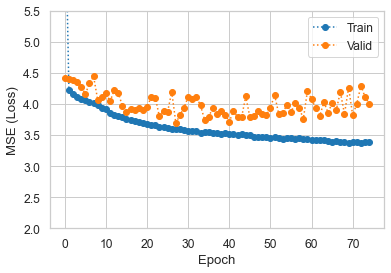

In [15]:
plt.plot(train_losses, 'o:', label='Train')
plt.plot(valid_losses, 'o:', label='Valid')
plt.ylim(2, 5.5)
plt.xlabel('Epoch')
plt.ylabel('MSE (Loss)')
plt.legend(loc=1)
plt.show()

One strategy to combat overfitting is to employ an Early Stopping condition. We monitor the loss on the validation set, and once it ceases to improve, we interrupt the training process.

With the following lines, train the model again, this time employing the Early Stopping condition. 

In [16]:
network = FullyConnectedNetwork()
network, train_losses, valid_losses = train_model(network, train_dataloader, valid_dataloader, max_epochs=max_epochs, learning_rate=learning_rate, early_stopping=True)

Epoch 0: train loss = 7.2924, valid loss = 4.6611
Epoch 1: train loss = 4.2336, valid loss = 4.3911
Epoch 2: train loss = 4.1928, valid loss = 4.3665
Epoch 3: train loss = 4.1692, valid loss = 4.2475
Epoch 4: train loss = 4.1376, valid loss = 4.4178
Epoch 5: train loss = 4.0890, valid loss = 4.1785
Epoch 6: train loss = 4.0430, valid loss = 4.1281
Epoch 7: train loss = 3.9960, valid loss = 4.0969
Epoch 8: train loss = 3.9719, valid loss = 4.2260
Epoch 9: train loss = 3.9258, valid loss = 4.1234
Epoch 10: train loss = 3.8967, valid loss = 3.9739
Epoch 11: train loss = 3.8722, valid loss = 4.6139
Epoch 12: train loss = 3.8447, valid loss = 4.0902
Epoch 13: train loss = 3.8472, valid loss = 4.0517
Applying early stopping condition after validation loss did not improve for 3 epochs.
Finished training in 14 epochs and 16.7 seconds.


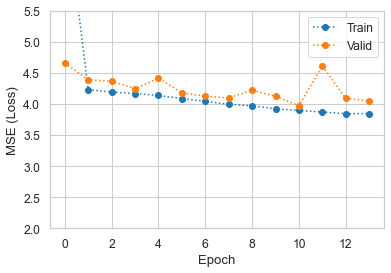

In [17]:
plt.plot(train_losses, 'o:', label='Train')
plt.plot(valid_losses, 'o:', label='Valid')
plt.ylim(2, 5.5)
plt.xlabel('Epoch')
plt.ylabel('MSE (Loss)')
plt.legend(loc=1)
plt.show()

Display the predictions and the true values. Ideally, these would lie on the red diagonal line. The root mean squared error (RMSE) is the quantity we use for evaluation. We train different models and compare the RMSE on the validation set to find the optimal one.

Prediction: Loss = 3.9739
--> RMSE = 1.99 m/s


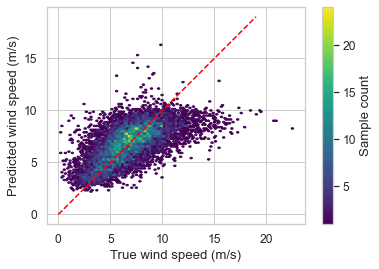

In [18]:
y_pred_valid = predict(network, valid_dataloader, include_plot=True)

## Advanced topics

We can improve the predictions by improving the model and/or improving the data

### Change the model capacity

Experiment with the dimension of the hidden layer by adjusting the values of units_dense1, units_dense2 in the following line of code. How does the dimension of the hidden layer affect the validation loss? Can you find a favorable set of values?

In [19]:
units_dense1 = 128
units_dense2 = 64

In [20]:
network = FullyConnectedNetwork(units_dense1=units_dense1, units_dense2=units_dense2)
network, train_losses, valid_losses = train_model(network, train_dataloader, valid_dataloader, max_epochs, early_stopping=True, learning_rate=learning_rate, verbose=False)

Applying early stopping condition after validation loss did not improve for 3 epochs.
Finished training in 15 epochs and 22.3 seconds.


Prediction: Loss = 3.8239
--> RMSE = 1.96 m/s


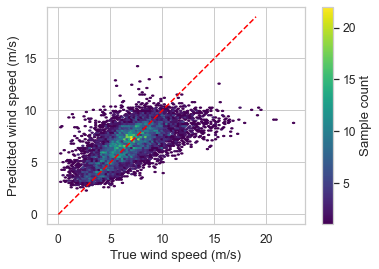

In [21]:
y_pred_valid = predict(network, valid_dataloader, include_plot=True)

### Add the quality filter to the data set

There are some samples in the data set that ended up having the wrong label. Such samples are confusing to the network and should be identified and removed. In the following line, the data set is reloaded using the flag "filter_quality=True", which in our implementation removes the mislabeled samples (complexity ...)

In [22]:
train_dataloader, valid_dataloader, test_dataloader = setup_dataloaders(filter_quality=True)

After filter_quality, 55903 samples remain (93.2%)
load and transform train input data: (55903, 1, 17, 11) (41.0MB)
load and transform train labels: (55903,) (0.0MB)
After filter_quality, 9466 samples remain (94.7%)
load and transform valid input data: (9466, 1, 17, 11) (7.0MB)
load and transform valid labels: (9466,) (0.0MB)
After filter_quality, 9382 samples remain (93.8%)
load and transform test input data: (9382, 1, 17, 11) (7.0MB)
load and transform test labels: (9382,) (0.0MB)


In [23]:
network = FullyConnectedNetwork(units_dense1=units_dense1, units_dense2=units_dense2)
network, train_losses, valid_losses = train_model(network, train_dataloader, valid_dataloader, max_epochs, early_stopping=True, learning_rate=learning_rate, verbose=False)

Applying early stopping condition after validation loss did not improve for 3 epochs.
Finished training in 17 epochs and 23.6 seconds.


Prediction: Loss = 3.2993
--> RMSE = 1.82 m/s


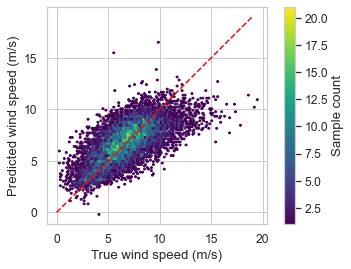

In [24]:
y_pred_valid = predict(network, valid_dataloader, include_plot=True)

### Add another channel

In the data set, we have one more type of input data available. So far, we restricted ourselves to the feature "brcs", but now we add the second feature "eff_scatter". We are still working with a fully connected network, all input data is flattened and concatenated.

In [25]:
train_dataloader, valid_dataloader, test_dataloader = setup_dataloaders(filter_quality=True, input_v_map=['brcs', 'eff_scatter'])

After filter_quality, 55903 samples remain (93.2%)
load and transform train input data: (55903, 2, 17, 11) (83.0MB)
load and transform train labels: (55903,) (0.0MB)
After filter_quality, 9466 samples remain (94.7%)
load and transform valid input data: (9466, 2, 17, 11) (14.0MB)
load and transform valid labels: (9466,) (0.0MB)
After filter_quality, 9382 samples remain (93.8%)
load and transform test input data: (9382, 2, 17, 11) (14.0MB)
load and transform test labels: (9382,) (0.0MB)


In [26]:
network = FullyConnectedNetwork(units_dense1=units_dense1, units_dense2=units_dense2, input_shape=(2,17,11))
network, train_losses, valid_losses = train_model(network, train_dataloader, valid_dataloader, max_epochs, early_stopping=True, learning_rate=learning_rate, verbose=False)

Applying early stopping condition after validation loss did not improve for 3 epochs.
Finished training in 11 epochs and 18.7 seconds.


Prediction: Loss = 2.8089
--> RMSE = 1.68 m/s


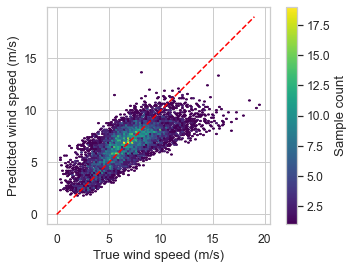

In [27]:
y_pred_valid = predict(network, valid_dataloader, include_plot=True)

### Run CNN instead of fully connected network

In [28]:
network = ConvolutionalNeuralNetwork(input_shape=(2,17,11), filters=32)
network, train_losses, valid_losses = train_model(network, train_dataloader, valid_dataloader, max_epochs, early_stopping=True, learning_rate=learning_rate, verbose=True)

Epoch 0: train loss = 3.4629, valid loss = 4.4653
Epoch 1: train loss = 2.7702, valid loss = 2.8738
Epoch 2: train loss = 2.7455, valid loss = 2.7157
Epoch 3: train loss = 2.6921, valid loss = 6.2184
Epoch 4: train loss = 2.6676, valid loss = 2.9465
Epoch 5: train loss = 2.6669, valid loss = 2.5539
Epoch 6: train loss = 2.6668, valid loss = 2.8530
Epoch 7: train loss = 2.6397, valid loss = 2.5427
Epoch 8: train loss = 2.6374, valid loss = 2.7544
Epoch 9: train loss = 2.5984, valid loss = 2.5441
Epoch 10: train loss = 2.5751, valid loss = 2.7024
Applying early stopping condition after validation loss did not improve for 3 epochs.
Finished training in 11 epochs and 171.8 seconds.


Prediction: Loss = 2.5427
--> RMSE = 1.59 m/s


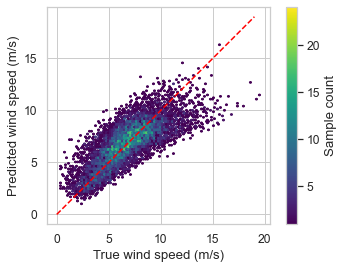

In [29]:
y_pred_valid = predict(network, valid_dataloader, include_plot=True)

## Evaluate the model on the test set

Finally, choose the model and training parameters that produced the best results on the validation set. Train the model, and use it to make predictions on the test set. Is the loss on the test set comparable to the loss on the validation set?

Prediction: Loss = 2.7306
--> RMSE = 1.65 m/s


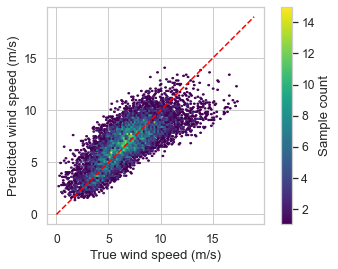

In [30]:
y_pred = predict(network, test_dataloader, include_plot=True)

In [31]:
print(f'Running the notebook took {(time.time()-notebook_start_time)/60} minutes')

Running the notebook took 5.861039380232493 minutes
